In [2]:
import sys
sys.path.insert(0, '../../python_dms/lib/')
from tools_dms import *
from dms import *
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.io
import time 
%load_ext autoreload
%autoreload 2
from skimage.metrics import structural_similarity as ssim


In [3]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [4]:
import os
def SegtoCon_DMS(seg):
    rows,cols = np.shape(seg)
    cont= np.zeros_like(seg)
    y=  np.zeros((rows,cols,2))
    y[:, :, 0] = np.concatenate((seg[:, 1:] - seg[:, 0:-1], np.zeros((rows, 1))),axis=1) / 2.
    y[:, :, 1] = np.concatenate((seg[1:, :] - seg[0:-1, :], np.zeros((1, cols))),axis=0) / 2.
    
    for i in range(rows):
        for j in range(cols):
            if np.abs(y[i,j,0]) > 0 or np.abs(y[i,j,1])>0:
                cont[i,j]=1
#                 im[i,j,:]=0
    return cont

def SegtoCon_DMS(seg):
    rows,cols = np.shape(seg)
    cont= np.zeros_like(seg)
    y=  np.zeros((rows,cols,2))
    y[:, :, 0] = np.concatenate((seg[:, 1:] - seg[:, 0:-1], np.zeros((rows, 1))),axis=1) / 2.
    y[:, :, 1] = np.concatenate((seg[1:, :] - seg[0:-1, :], np.zeros((1, cols))),axis=0) / 2.
    
    for i in range(rows):
        for j in range(cols):
            if np.abs(y[i,j,0]) > 0 or np.abs(y[i,j,1])>0:
                cont[i,j]=1
#                 im[i,j,:]=0
    return cont

In [5]:

np.random.seed(0)

x = np.array(Image.open('../../testset/10081.jpg'))/255.
# x = np.array(Image.open('../../testset/12003.jpg'))/255.

rows,cols,_ = np.shape(x)
delta= 0.05
# print(np.random.normal(0,1,x.shape).shape)
z = x+ delta*np.random.normal(0,1,x.shape)



In [6]:
PSNR(original=x,compressed=z)

26.030380604253548

In [7]:
def GradientHor(x):
    y=x-np.roll(x,1,axis=1)
    y[:,0]=0
    return y
def GradientVer(x):
    y=x-np.roll(x,1,axis=0)
    y[0,:]=0
    return y




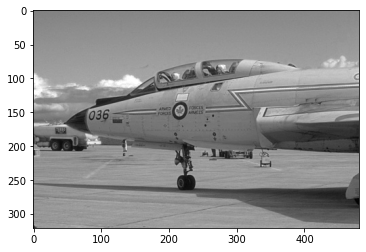

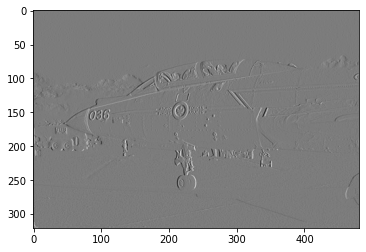

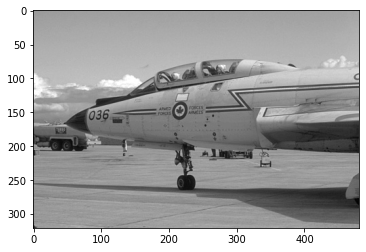

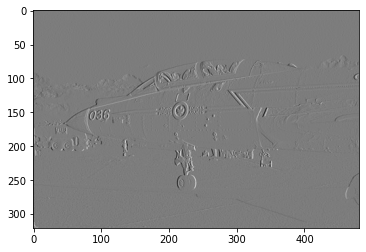

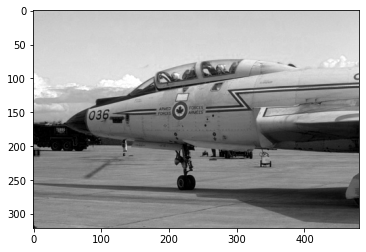

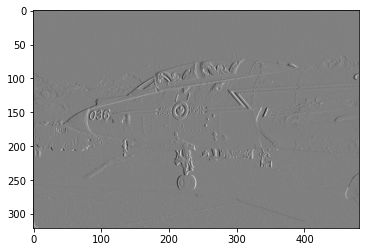

In [8]:
plt.figure()
plt.imshow(x[:,:,0],cmap='gray')
plt.show()


plt.figure()
plt.imshow(GradientHor(x[:,:,0]),cmap='gray')
plt.show()


plt.figure()
plt.imshow(x[:,:,1],cmap='gray')
plt.show()

plt.figure()
plt.imshow(GradientHor(x[:,:,1]),cmap='gray')
plt.show()


plt.figure()
plt.imshow(x[:,:,2],cmap='gray')
plt.show()

plt.figure()
plt.imshow(GradientHor(x[:,:,2]),cmap='gray')
plt.show()


In [21]:
original = np.copy(x)

In [9]:
PSNR(x,compressed=z)

26.030380604253548

In [10]:

## Without GGS
slpam_l1_solver = DMS(
        norm_type="l1",
        edges="similar",
        beta=8,
        lamb=1e-2,
        eps=0.2,
        stop_criterion=1e-4,
        MaximumIteration=250,
        method="SLPAM",
        noised_image_input=z,
        optD="OptD",
        dk_SLPAM_factor=1e-4,
        eps_AT_min=0.02,
        A=np.ones((rows,cols)))

In [11]:
time1 = time.time()
out_slpam_l1 = slpam_l1_solver.process()
time_slpam_l1 = time.time()-time1

100%|█████████████████████████████████████████████████████████████| 250/250 [00:30<00:00,  8.17it/s]


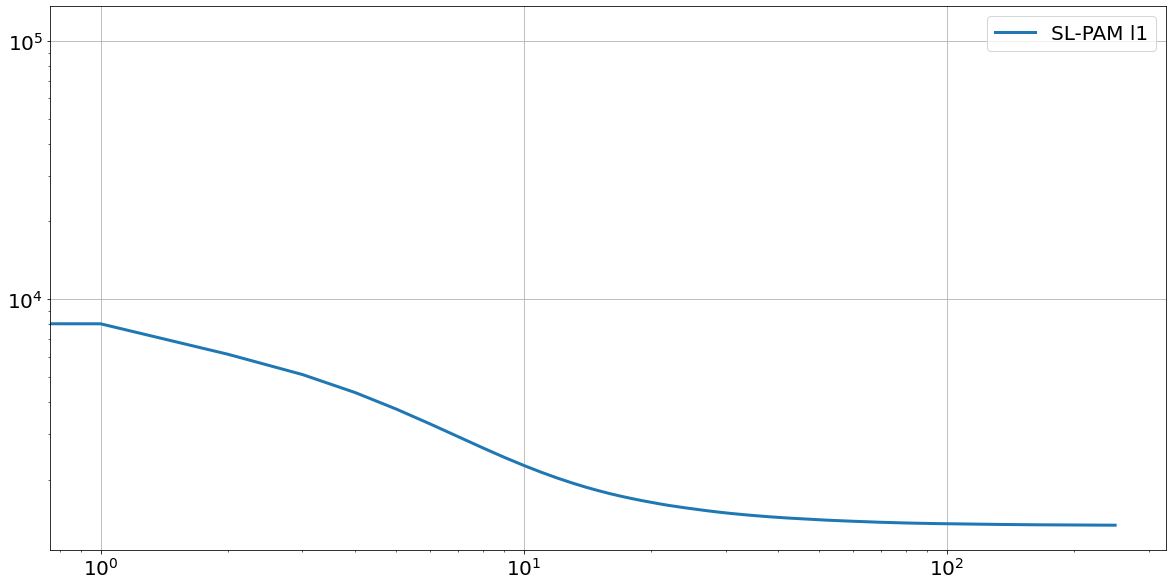

In [12]:
plt.figure(figsize=(20,10))
plt.loglog(out_slpam_l1[2], linewidth=3,label='SL-PAM l1')
plt.legend(fontsize=20)
plt.grid('on')
plt.tick_params(axis='both', which='major', labelsize=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


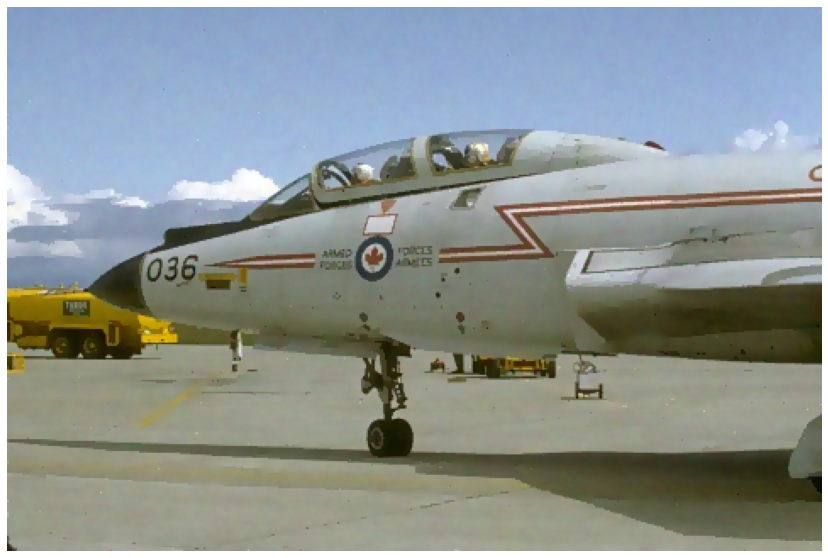

In [13]:

plt.figure(figsize=(20,10))
plt.imshow(out_slpam_l1[1])
plt.axis('off')
plt.savefig('x_est_l1.png', bbox_inches='tight', pad_inches=0)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


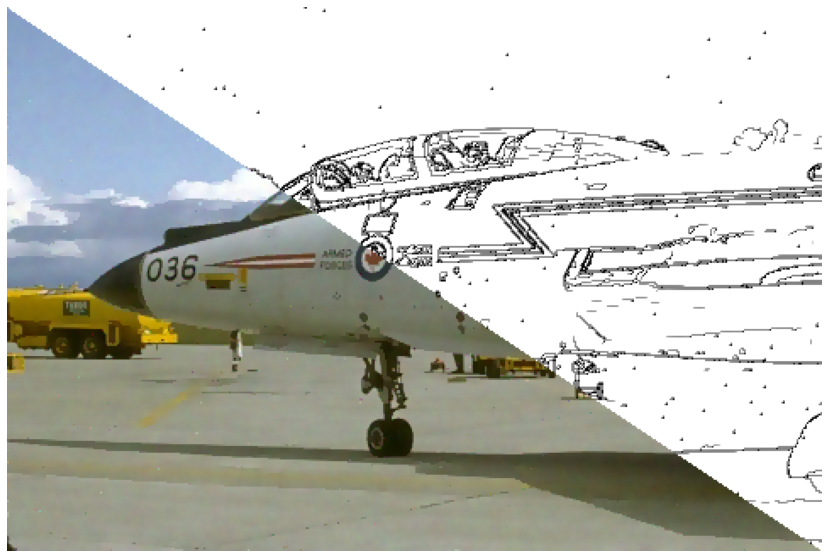

In [14]:
plt.figure(figsize=(20,10))
e1 = out_slpam_l1[0][:,:,0]+out_slpam_l1[0][:,:,1]#np.clip(out_slpam_l1[0][:,:,0]+out_slpam_at[0][:,:,1],0,1)#
x1 = out_slpam_l1[1]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_l1_big_lamb.png', bbox_inches='tight', pad_inches=0)
plt.show()

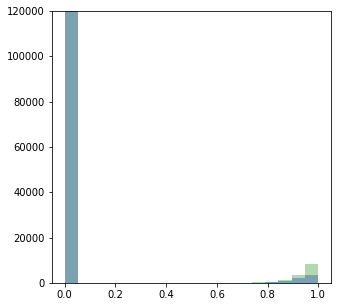

In [15]:
bins = np.linspace(0, 1, 20)
plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_l1[0][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_l1[0][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_slpam_l1_big_lamb.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

In [16]:
PSNR(original=original,compressed=out_slpam_l1[1])

NameError: name 'original' is not defined

In [20]:
mat_file_path = "../../../../../Documents/dataset/BSDS500/data/groundTruth/test/10081.mat"
# mat_file_path = "../../../../../Documents/dataset/BSDS500/data/groundTruth/train/12003.mat"
# mat_file_path = "../../../../Documents/dataset/BSDS500/data/groundTruth/train/12003.mat"


mat_file = scipy.io.loadmat(mat_file_path)

cont= np.zeros((rows,cols))
for v in range(0,5):
    seg = mat_file['groundTruth'][0,v][0,0][0]
    cont += SegtoCon_DMS(seg)
cont = np.where(cont > 0, 1, 0)


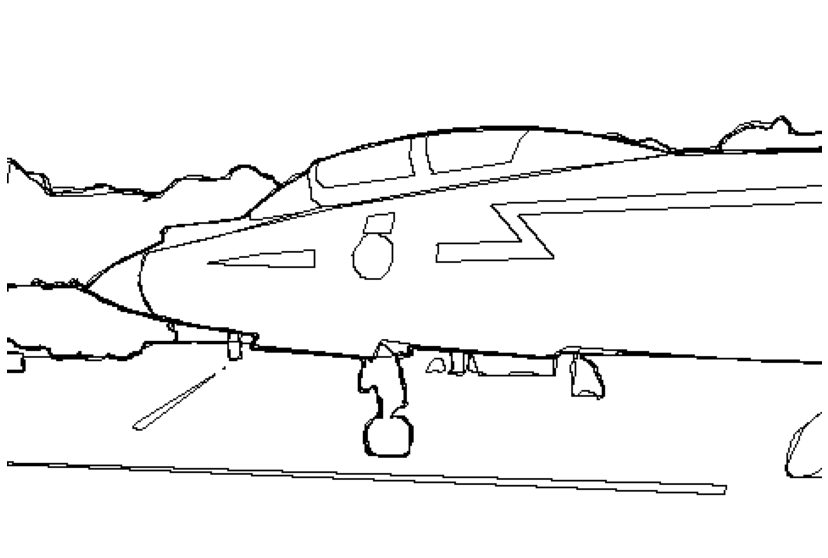

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(cont,cmap='gray_r')
plt.axis('off')
plt.savefig('cont_gt_10081.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [22]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [23]:
cross_entropy(predictions=est_cont,targets=cont)

NameError: name 'est_cont' is not defined

In [ ]:
est_cont= (out_slpam_l1[0][:,:,0]+out_slpam_l1[0][:,:,1])
plt.figure(figsize=(10,5))
plt.imshow(est_cont,cmap='gray_r')
plt.axis('off')
plt.show()
print(ssim(est_cont,cont,data_range=1))
print(jaccard(est_cont,cont))


In [ ]:
# est_cont_at = np.clip((out_slpam_at[4][5][:,:,0]+out_slpam_at[4][5][:,:,1]),0,1)
est_cont_at =((out_slpam_at[4][5][:,:,0]+out_slpam_at[4][5][:,:,1]))

plt.figure(figsize=(10,5))
plt.imshow(est_cont_at,cmap='gray_r')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(original)
plt.axis('off')
plt.show()

In [ ]:
est_cont.shape

In [ ]:
est_cont_at = ((out_slpam_at[4][5][:,:,0]+out_slpam_at[4][5][:,:,1]))/2
est_cont = (out_slpam_l1[0][:,:,0]+out_slpam_l1[0][:,:,1])/2
plt.figure(figsize=(20,5))
plt.plot(cont[100,:])
plt.plot(est_cont[100,:]>0.5)
plt.plot(est_cont_at[100,:]>0.5)

plt.show()


In [ ]:

## Without GGS
slpam_l1_solver = DMS(
        norm_type="l1",
        edges="similar",
        beta=8,
        lamb=8e-3,
        eps=0.2,
        stop_criterion=1e-4,
        MaximumIteration=250,
        method="SLPAM",
        noised_image_input=z,
        optD="OptD",
        dk_SLPAM_factor=1e-4,
        eps_AT_min=0.02,
        A=np.ones((rows,cols)))

In [ ]:
time1 = time.time()
out_slpam_l1 = slpam_l1_solver.process()
time_slpam_l1 = time.time()-time1

In [ ]:
out_slpam_l1[0][:,:,0]

In [ ]:
plt.figure(figsize=(20,10))
e1 = out_slpam_l1[0][:,:,0]+out_slpam_l1[0][:,:,1]
x1 = out_slpam_l1[1]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_l1_small_lamb.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
bins = np.linspace(0, 1, 20)
plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_l1[0][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_l1[0][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_slpam_l1_small_lamb.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

In [ ]:
PSNR(original=original,compressed=out_slpam_l1[1])

In [ ]:
est_cont =(out_slpam_l1[0][:,:,0]+out_slpam_at[0][:,:,1])/2
ssim(cont,est_cont)

In [24]:

## Without GGS
slpam_at_solver = DMS(
        norm_type="AT",
        edges="similar",
        beta=5.2,
        lamb=0.001,
        eps=0.025,
        stop_criterion=1e-5,
        MaximumIteration=150,
        method="SLPAM-eps-descent",
        noised_image_input=z,
        optD="OptD",
        dk_SLPAM_factor=1e-5,
        eps_AT_min=0.009,
        A=np.ones((rows,cols)))

palm_at_solver = DMS(
        norm_type="AT",
        edges="similar",
        beta=5.2,
        lamb=0.001,
        eps=0.025,
        stop_criterion=1e-8,
        MaximumIteration=3000,
        method="PALM-eps-descent",
        noised_image_input=z,
        optD="OptD",
        eps_AT_min=0.009,
        A=np.ones((rows,cols)))



Epsilon:  0.025


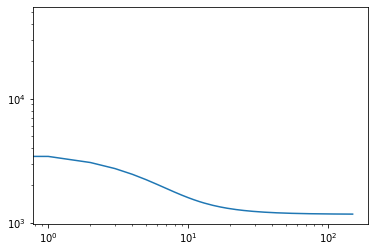

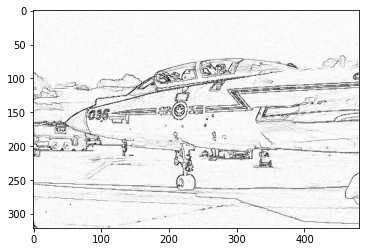

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


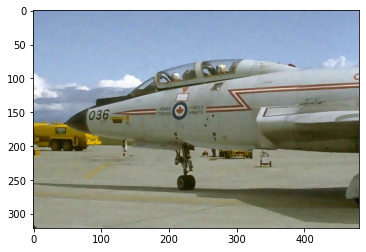

Epsilon:  0.01785714285714286


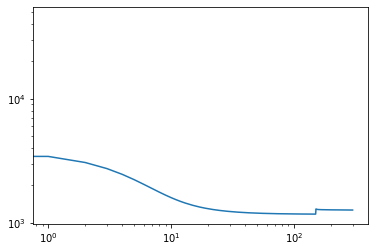

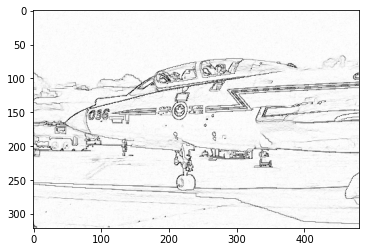

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


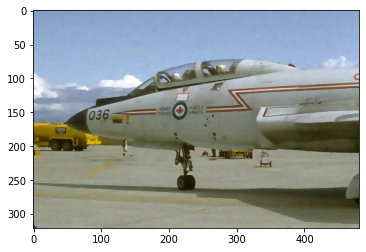

Epsilon:  0.012755102040816329


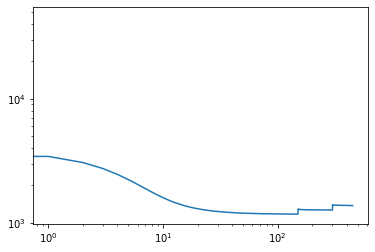

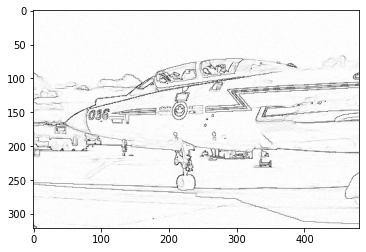

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


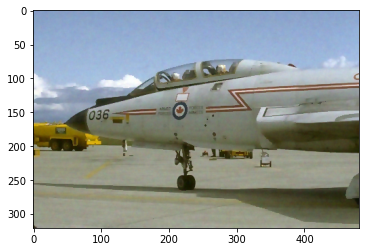

Epsilon:  0.009110787172011664


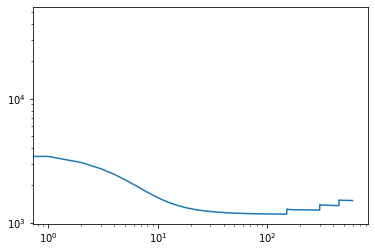

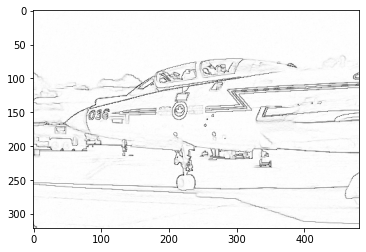

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


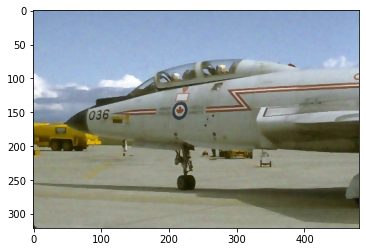

In [25]:
time1 = time.time()
out_slpam_at = slpam_at_solver.process()
time_slpam_at = time.time()-time1

Epsilon:  0.025


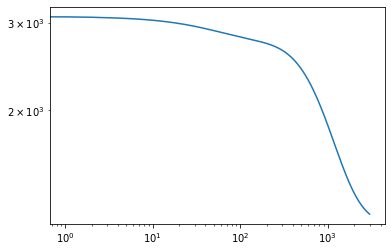

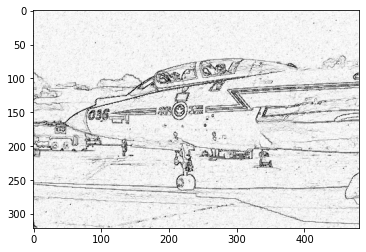

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


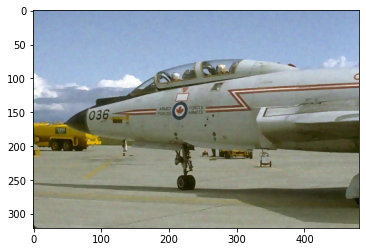

Epsilon:  0.01785714285714286


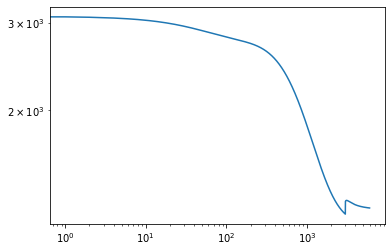

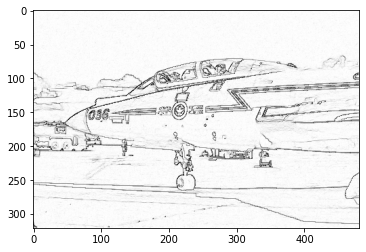

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


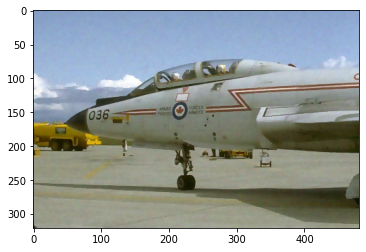

Epsilon:  0.012755102040816329


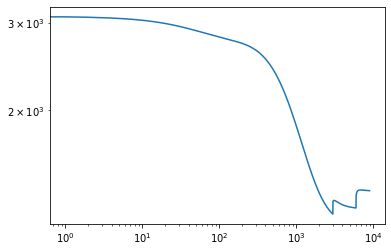

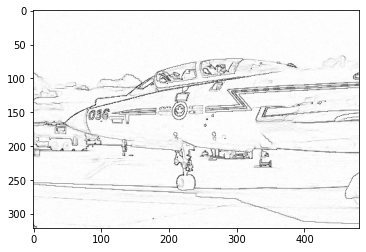

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


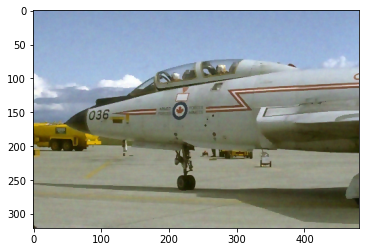

Epsilon:  0.009110787172011664


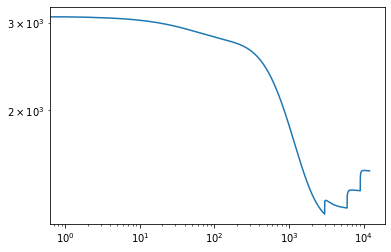

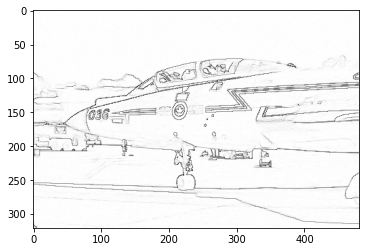

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


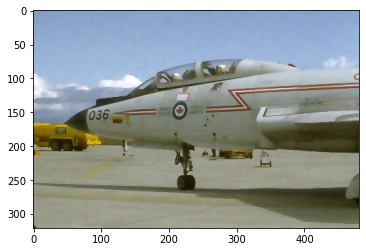

In [26]:
time2 = time.time()
out_palm_at = palm_at_solver.process()
time_palm_at= time.time()-time2

In [ ]:
# print("SLPAM-CT:",time_slpam_at)
print("PALM-CT:",time_palm_at)

In [ ]:
np.max(out_palm_at[4][0][:,:,0])

In [17]:
for r in range(round):
#     plt.figure(figsize=(20,10))
    plt.imshow(out_palm_at[4][r][:,:,0]+out_palm_at[4][r][:,:,1],cmap='gray_r')
    plt.axis('off')
#     plt.savefig('e_eps_'+str(r)+'.png', bbox_inches='tight', pad_inches=0)
    plt.show()
#     print(ssim((out_slpam_at[4][r][:,:,0]+out_slpam_at[4][r][:,:,1])/2>0.5,cont,data_range=1))
#     print(jaccard((time[4][r][:,:,0]+out_slpam_at[4][r][:,:,1])/2>0.5,cont))




TypeError: 'builtin_function_or_method' object cannot be interpreted as an integer

/tmp/ipykernel_22717/3187638630.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,12000)


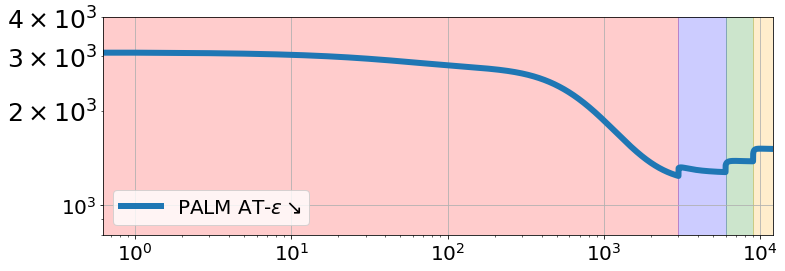

In [42]:
plt.figure(figsize=(12,4))
# plt.loglog(out_slpam_at[2], linewidth=3,label='SL-PAM AT-decreasing-$\epsilon$')
plt.loglog(out_palm_at[2], linewidth=6,label='PALM AT-$\epsilon\searrow$')
plt.axvspan(0, 3000, alpha=0.2, color='red')
plt.axvspan(3000, 6000, alpha=0.2, color='blue')
plt.axvspan(6000,9000 , alpha=0.2, color='green')
plt.axvspan(9000, 12000, alpha=0.2, color='orange')

plt.legend(fontsize=20)
plt.rcParams.update({'font.size': 25})

plt.grid('on')
plt.ylim(0.8e3,4e3)
plt.xlim(0,12000)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('palm_crit_dms_at_compare_decreasing_eps.png', bbox_inches='tight', pad_inches=0)


/tmp/ipykernel_22717/1295815011.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,12000)


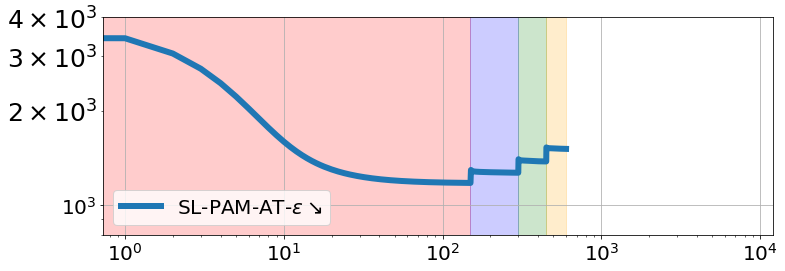

In [43]:
plt.figure(figsize=(12,4))
# plt.loglog(out_slpam_at[2], linewidth=3,label='SL-PAM AT-decreasing-$\epsilon$')
plt.loglog(out_slpam_at[2], linewidth=6,label='SL-PAM-AT-$\epsilon\searrow$')
plt.axvspan(0, 150, alpha=0.2, color='red')
plt.axvspan(150, 300, alpha=0.2, color='blue')
plt.axvspan(300,450 , alpha=0.2, color='green')
plt.axvspan(450, 600, alpha=0.2, color='orange')
plt.legend(fontsize=20)
plt.rcParams.update({'font.size': 25})

plt.grid('on')
plt.ylim(0.8e3,4e3)
plt.xlim(0,12000)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('slpam_crit_dms_at_compare_decreasing_eps.png', bbox_inches='tight', pad_inches=0)


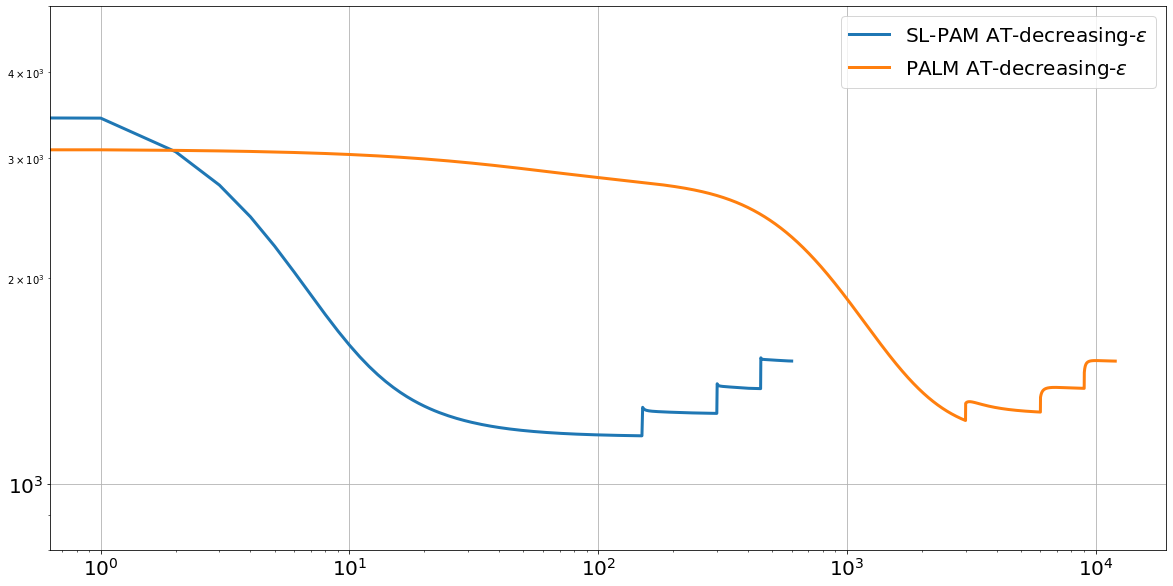

In [38]:
plt.figure(figsize=(20,10))
# plt.loglog(out_slpam_at[2], linewidth=3,label='SL-PAM AT-decreasing-$\epsilon$')
plt.plot(out_slpam_at[2], linewidth=3,label='SL-PAM AT-decreasing-$\epsilon$')

plt.loglog(out_palm_at[2], linewidth=3,label='PALM AT-decreasing-$\epsilon$')
plt.legend(fontsize=20)
plt.grid('on')
plt.ylim(0.8e3,5e3)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('crit_dms_at_compare_decreasing_eps.png', bbox_inches='tight', pad_inches=0)


In [ ]:
round,_,_,_=np.shape(out_slpam_at[4])

In [ ]:
round,_,_,_=np.shape(out_palm_at[4])

In [ ]:
plt.imshow(out_palm_at[0][:,:,1])

In [ ]:
plt.hist(out_palm_at[0][:,:,1].flatten())

In [ ]:
plt.figure(figsize=(20,10))
e1 = out_palm_at[0][:,:,0]+out_palm_at[0][:,:,1]
x1 = out_palm_at[1]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
plt.figure(figsize=(20,10))
e1 = out_palm_at[4][round-1][:,:,0]+out_palm_at[4][round-1][:,:,1]
x1 = out_palm_at[3][round-1]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][round-1][:,:,0]+out_slpam_at[4][round-1][:,:,1]
x1 = out_slpam_at[3][round-1]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
est_cont = (out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1])/2
print(np.mean((est_cont - cont) ** 2))
ssim(est_cont,cont,data_range=1)

In [ ]:
plt.figure(figsize=(20,10))
e1 = cont
x1 =original
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_cont.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:

plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[1])
plt.axis('off')
plt.savefig('x_est_at_decreasing.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
print(jaccard(np.zeros_like(cont),cont))

In [ ]:
for r in range(round):
    plt.figure(figsize=(20,10))
    plt.imshow(out_slpam_at[4][r][:,:,0]+out_slpam_at[4][r][:,:,1],cmap='gray_r')
    plt.axis('off')
#     plt.savefig('e_eps_'+str(r)+'.png', bbox_inches='tight', pad_inches=0)
    plt.show()
#     print(ssim((out_slpam_at[4][r][:,:,0]+out_slpam_at[4][r][:,:,1])/2>0.5,cont,data_range=1))
    print(jaccard((out_slpam_at[4][r][:,:,0]+out_slpam_at[4][r][:,:,1])/2>0.5,cont))




In [ ]:
for r in range(round):
    plt.figure(figsize=(20,10))
    e1 = out_slpam_at[4][r][:,:,0]+out_slpam_at[4][r][:,:,1]
    x1 = out_slpam_at[3][r]
    x=np.copy(x1)
    for i in range(rows):
        # Loop through each column
        for j in range(cols):
            # If the column index is greater than the row index, it's an element in the upper diagonal
            if j > i*(481/321):
                x[i,j,0]=1-e1[i,j]/2
                x[i,j,1]=1-e1[i,j]/2
                x[i,j,2]=1-e1[i,j]/2
    plt.imshow(x)
    plt.axis('off')
#     plt.savefig('x_est_eps_'+str(r)+'.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    print(PSNR(original,x1))
    print(ssim((out_slpam_at[4][r][:,:,0]+out_slpam_at[4][r][:,:,1])/2,cont,data_range=1))
    print(jaccard((out_slpam_at[4][r][:,:,0]+out_slpam_at[4][r][:,:,1])/2,cont))


In [ ]:
bins = np.linspace(0, 1, 20)
plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][0][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][0][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][1][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][1][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][2][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][2][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][3][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][3][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][4][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][4][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][5][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][5][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][0][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][1][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][2][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][3][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][4][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][5][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][0][200:400,200:400,0]+out_slpam_at[4][0][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][1][200:400,200:400,0]+out_slpam_at[4][1][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][2][200:400,200:400,0]+out_slpam_at[4][2][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][3][200:400,200:400,0]+out_slpam_at[4][3][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][4][200:400,200:400,0]+out_slpam_at[4][4][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][5][200:400,200:400,0]+out_slpam_at[4][5][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
np.shape(out_slpam_at[4][0])